**Introduction**
<p>Putting some of my newly developed Data Science skills to work. <br/>
Any feedback is welcome🙏</p>

The Challenge:<br/>
> In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [159]:
import os
import warnings
warnings.filterwarnings("ignore")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [160]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import urllib
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import classification_report

In [161]:
dims = (6,6)
fig, ax = plt.subplots(figsize=dims)
sns.set_style('whitegrid')
sns.set_color_codes("colorblind")
%matplotlib inline

**Exploratory & Data Cleaning Phases** <br/>
The output from the code below reveals that three features have missing/null data (Age, Cabin, and Embarked)

In [162]:
#reading in data
gender_data = pd.read_csv("gender_submission.csv")
test_data = pd.read_csv("test.csv")
training_data = pd.read_csv("train.csv")
#training_data.head()
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Label encoding the sex and embarked columns for later use

In [163]:
cleanup_genders = {"Sex":{"male": 1, "female": 2},}
training_data.replace(cleanup_genders, inplace=True)

cleanup_embarked = {"Embarked":{"S": 1, "C": 2, 'Q':3},}
training_data.replace(cleanup_embarked, inplace=True)

# with the above code, replaced sex values with numerical data 
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,2.0
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1.0


In [164]:
cleanup_genders = {"Sex":{"male": 1, "female": 2},}
test_data.replace(cleanup_genders, inplace=True)

cleanup_embarked = {"Embarked":{"S": 1, "C": 2, 'Q':3},}
test_data.replace(cleanup_embarked, inplace=True)

# with the above code, replaced sex values with numerical data 
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,363272,7.0000,NaN,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,3
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,3101298,12.2875,NaN,1


In [165]:
cleaned_test = test_data.fillna(method="ffill")

Exploring any correlations that may exist within the training data

1. Below we see a significant coorelation between Sex and Survived
2. We also see that Fare seems to have a small correlation with Survived as well
3. Passenger Class (Pclass) has a negative correlation with Survived. This seems to be due to the corr function interpreting the values differently. So 1 is seen as lesser than 3, but for our purposes it is the opposite.

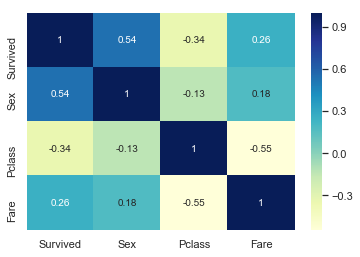

In [166]:
training_corr = training_data[['Survived', 'Sex', 'Pclass', 'Fare']].corr()
sns.heatmap(training_corr, cmap="YlGnBu", annot=True)

In [167]:
training_data.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.036847,-0.057527,-0.001652,0.012658,-0.030555
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,0.108669
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.043835
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,0.118593
Age,0.036847,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,0.012186
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,-0.060606
Parch,-0.001652,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,-0.079320
Fare,0.012658,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,0.063462
Embarked,-0.030555,0.108669,0.043835,0.118593,0.012186,-0.060606,-0.079320,0.063462,1.000000


Visualizing the training_data to see if any significant correlations or outliers exist.<br/>
Can take away from the below charts that quite a few features are binomial or multinomial and are non linearally correlated

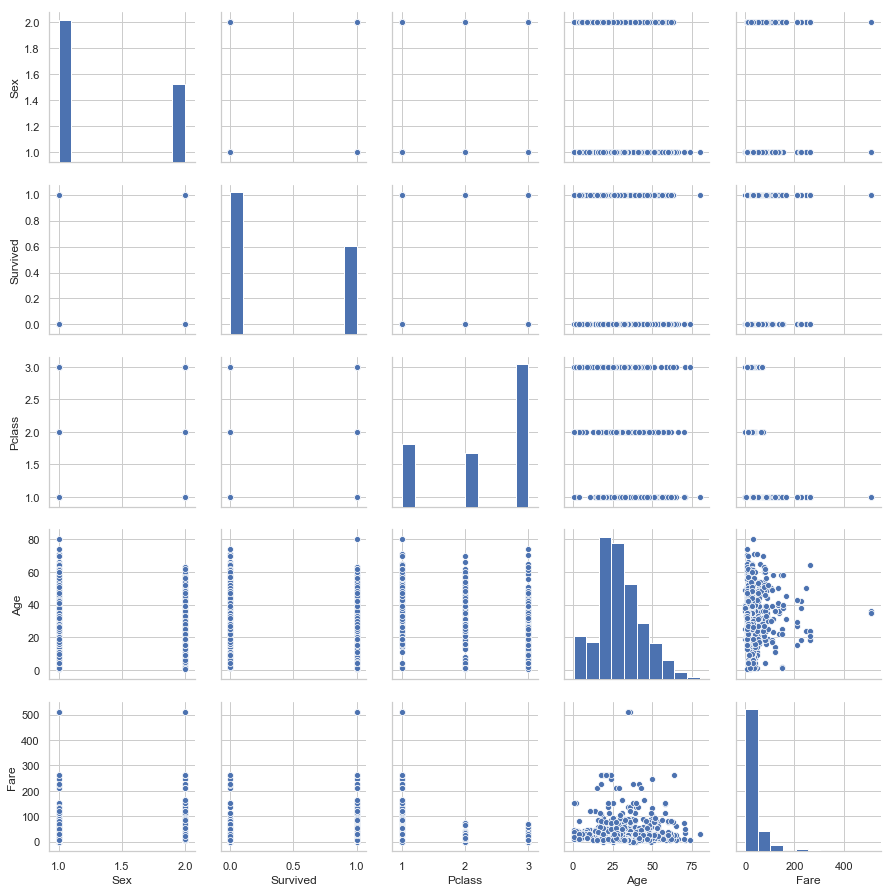

In [168]:
sns.pairplot(training_data[['Sex', 'Survived', 'Pclass', 'Age', 'Fare']])

Survival based on age

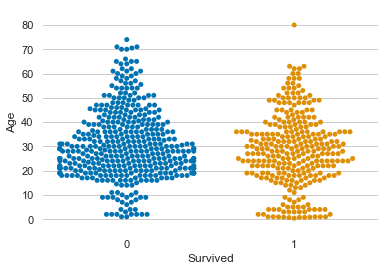

In [169]:
sns.swarmplot(x="Survived", y="Age", data=training_data[['Age', 'Survived']],
             palette="colorblind")
sns.despine(top=True, right=True, left=True, bottom=True)

The average purchase prices of the fare grouped by Passenger Class (Pclass)

In [170]:
Pclass = pd.DataFrame(training_data.groupby(["Pclass"]).Fare.mean())
Pclass

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


The purchase prices of the fare grouped by Passenger Class (Pclass)

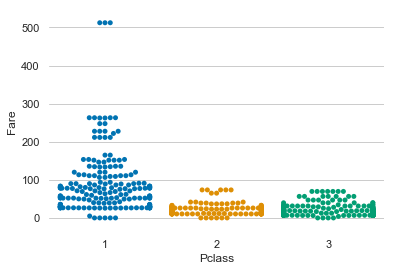

In [171]:
sns.swarmplot(x="Pclass", y="Fare", data=training_data[['Fare', 'Pclass']],
            palette="colorblind")
sns.despine(top=True, right=True, left=True, bottom=True)

Visualizing the distribution of survivors based on sex and class

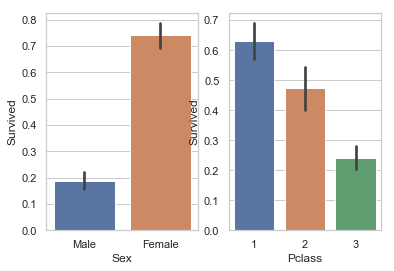

In [172]:
plt.subplot(1,2,1)
sex_vs_survived_plot = sns.barplot(x="Sex", y="Survived",
            data=training_data);
# sex_vs_survived_plot.fig.set_size_inches(3.5, 3.5)
#sex_vs_survived_plot.title("Survival based on Sex")
sex_vs_survived_plot.set(xticklabels=["Male", "Female"])

plt.subplot(1,2,2)
pclass_vs_survived_plot = sns.barplot(x="Pclass", y="Survived",
            data=training_data);
# pclass_vs_survived_plot.fig.set_size_inches(3.5, 3.5)
#pclass_vs_survived_plot.title("Survival based on Class")

Fill missing values in "Age" column with the mean of all ages given

In [173]:
avg_age = training_data.Age.mean()
#was having issues filling in with avg age
new_training_set = training_data.fillna(method="ffill")
new_training_set.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.00,C50,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",2,19.0,0,0,112053,30.00,B42,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,19.0,1,2,W./C. 6607,23.45,B42,1.0
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.00,C148,2.0
890,891,0,3,"Dooley, Mr. Patrick",1,32.0,0,0,370376,7.75,C148,3.0


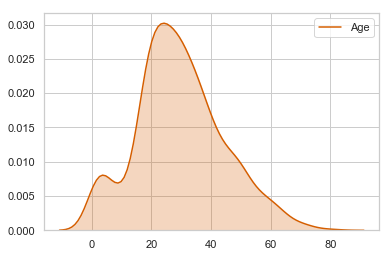

In [174]:
# new_training_set.Age.astype(int)
# age distribution
p1=sns.kdeplot(new_training_set.Age, shade=True, color="r");

Gathering how many men and women were on board the ship

In [175]:
training_data['Sex'].value_counts()

1    577
2    314
Name: Sex, dtype: int64

[[Text(0, 0, 'Male'), Text(0, 0, 'Female')]]

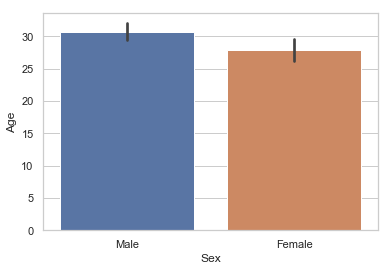

In [176]:
# age ranges of the men and women aboard
# 1 being male 2 being female
sex_age_plot = sns.barplot(x=training_data['Sex'], y=training_data['Age'])
sex_age_plot.set(xticklabels=["Male", "Female"])

The manifest seems to have listed peoples titles such as "Miss", "Mrs", and "Mr" <br/> 
Due to this I am able to loop through the data and assume if the women aboard were single or not then check the mortality rate based off of their relationship status

In [177]:
## creating a new column to append to the training dataframe
## analyzing how many married woman were onboad and their mortality rate
## 1 denoting married 0 denoting single
count = 0
married_woman = []
for name in new_training_set['Name']:
    
    if "Mrs" in name:
        count += 1
        married_woman.append(1)
    elif "Miss" or "Ms":
        married_woman.append(0)  
        
new_training_set['Women Relationship Status'] = married_woman

[[Text(0, 0, 'Single'), Text(0, 0, 'Married')]]

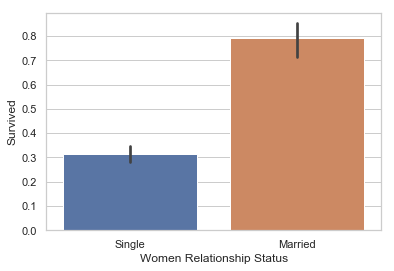

In [178]:
married_vs_unmarried_plot = sns.barplot(x="Women Relationship Status", y="Survived",
            data=new_training_set);
married_vs_unmarried_plot.set(xticklabels=["Single", "Married"])

**Machine Learning and Prediction Phase**
<br/>

Models used: 
* XG Boost
* Logistic Regression
* K Means Nearest Neighbor
<br/>

Instantiaing the XG Boost model to predict the likihood of survival based on Sex, Passenger Class, Fare, and Age

In [179]:
xgboost_model = XGBRegressor()
cols_to_use = ['Sex', 'Pclass', 'Fare', 'Age']
X = new_training_set[cols_to_use]
y = new_training_set.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=2)
xgboost_model.fit(X_train, y_train)

[22:50:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [180]:
predictions = xgboost_model.predict(X_val)
XGBoostMAE = mean_absolute_error(predictions, y_val)
print("Mean Absolute Error: " + str(XGBoostMAE))

Mean Absolute Error: 0.276935160026422


Instantiaing a Linear Regression model to predict the likihood of survival based on:
* Sex
* Passenger Class 
* Fare
* Age
* PassengerId
* Embarked
* Parch
* SibSp

In [181]:
LogRegression = LogisticRegression()
cols_to_use = ['Sex', 'Pclass', 'Fare', 'Age', 'PassengerId', 'Embarked', 'Parch', 'SibSp']
X = new_training_set[cols_to_use]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=2)
LogRegression.fit(X_train,y_train)
logRegScore = LogRegression.score(X_train,y_train)
print(logRegScore)

0.8098802395209581


In [182]:
logRegPred = LogRegression.predict(cleaned_test[cols_to_use])

Instantiaing a K Means Nearest Neighbor model to predict the likihood of survival based on Sex, Passenger Class, Fare, and PassengerId

In [183]:
## K MNN
cols_to_use = ['Sex', 'Pclass', 'Fare', 'PassengerId']
X_prime = new_training_set[cols_to_use].values
X = preprocessing.scale(X_prime)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=17)

In [184]:
clf = neighbors.KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [185]:
y_expect = y_test
y_pred = clf.predict(X_test)

print(classification_report(y_expect, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       131
           1       0.76      0.64      0.69        92

    accuracy                           0.77       223
   macro avg       0.76      0.75      0.75       223
weighted avg       0.77      0.77      0.76       223



Instantiaing a Random Forest model to predict the likihood of survival based on:

* Sex
* Passenger Class 
* Fare
* Age
* PassengerId
* Embarked
* Parch
* SibSp

In [186]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state=2)
forest_model.fit(X_train, y_train)
forest_score = forest_model.score(X_train,y_train)
print(forest_score)
forest_pred = forest_model.predict(cleaned_test[cols_to_use])

0.9775449101796407


In [187]:
forest_pred = forest_model.predict(cleaned_test[cols_to_use])

Creating Submission

In [188]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = logRegPred
submission.to_csv('logreg_titanic_submission.csv', index=False)
titanic_sub = pd.read_csv('logreg_titanic_submission.csv')
titanic_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Submission for Random Forest Tree Model

In [189]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = forest_pred
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('titanic_submission.csv', index=False)
titanic_sub = pd.read_csv('titanic_submission.csv')
titanic_sub.head()

,PassengerId,Survived
0,892,1
1,893,0
2,894,1
3,895,1
4,896,1
